# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# A Machine Learning Approach to Insurance Benefit Prediction: Classification, Regression, and Data Obfuscation

This project aims to predict insurance benefit outcomes using supervised machine learning techniques, addressing both classification (whether a benefit is received) and regression (the amount of benefit) tasks. The workflow includes data preprocessing, exploratory analysis, and the application of models such as k-Nearest Neighbors and Linear Regression. Model performance is assessed using metrics including F1 score, RMSE, and $R^2$, with additional comparisons made against baseline dummy classifiers. The study further examines the impact of feature scaling on model effectiveness and includes a custom implementation of linear regression. Finally, the project analytically and computationally demonstrates that linear regression remains invariant under linear transformations of the feature space.


Heather Marie Culligan 

April 2025

# Data Preprocessing & Exploration

## Initialization

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.neighbors
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

from numpy.linalg import inv
from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4215,1,24.0,48100.0,2,0
1862,1,28.0,46600.0,1,0
3345,0,20.0,44200.0,1,0
2152,1,20.0,39200.0,1,0
2624,1,19.0,37300.0,0,0
247,1,41.0,33800.0,1,0
153,0,20.0,35200.0,1,0
3830,1,26.0,46200.0,2,0
4907,1,41.0,45200.0,0,0
537,0,20.0,38700.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
df['age'] = df['age'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
df.duplicated().sum()

153

In [10]:
df.isnull().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [11]:
features = df.drop(columns='insurance_benefits')
target = df['insurance_benefits']

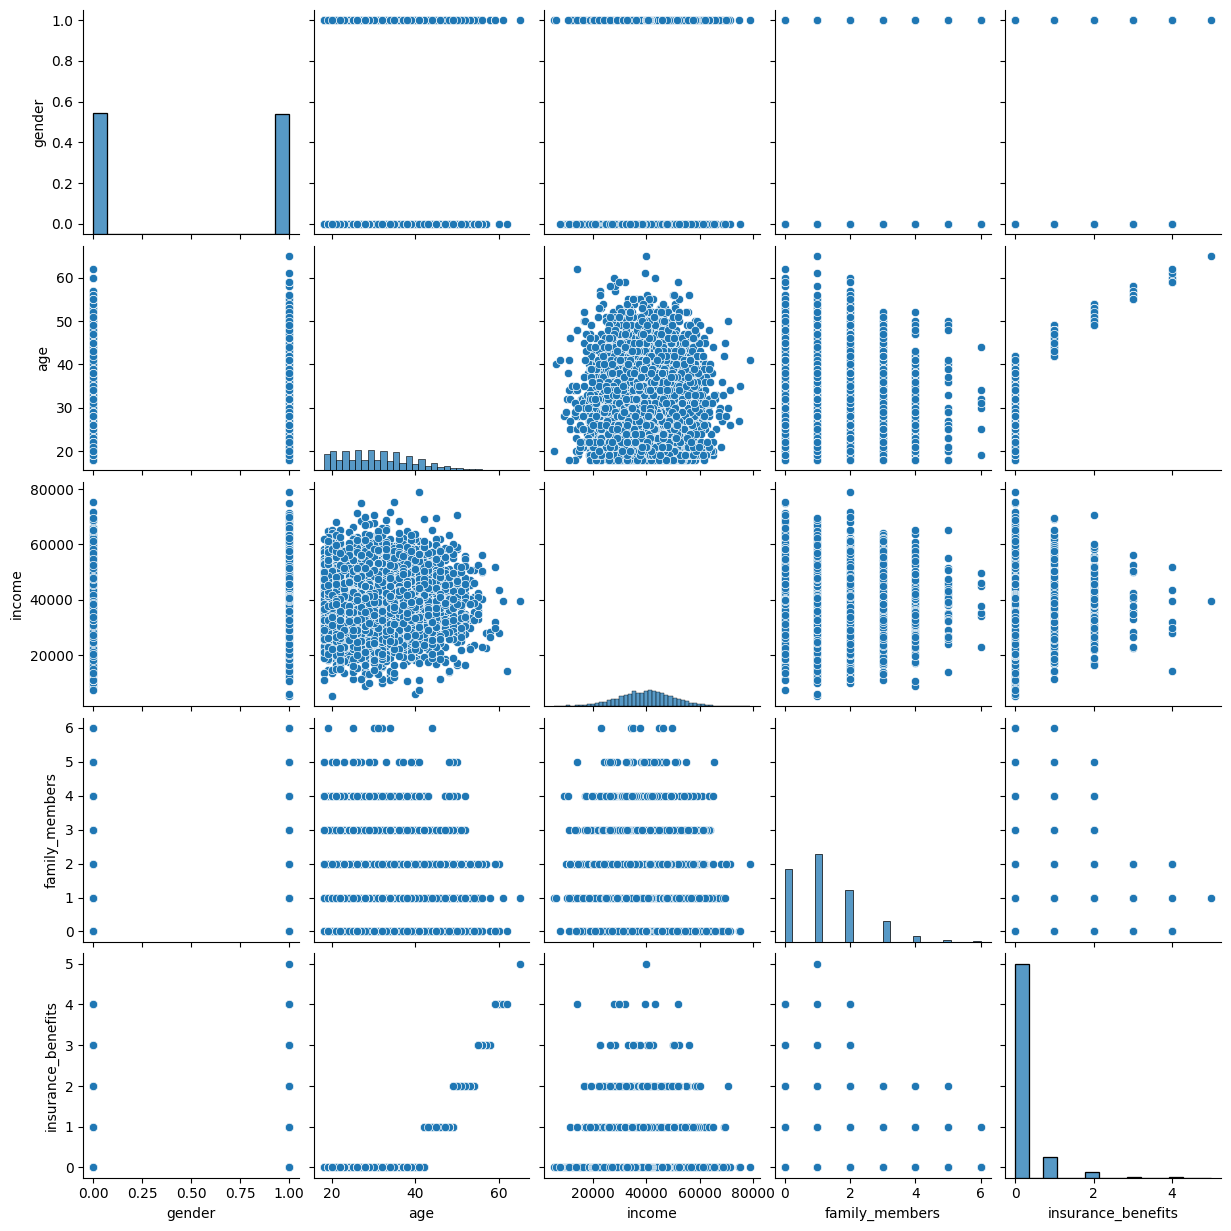

In [12]:
sns.pairplot(df)
plt.show()

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

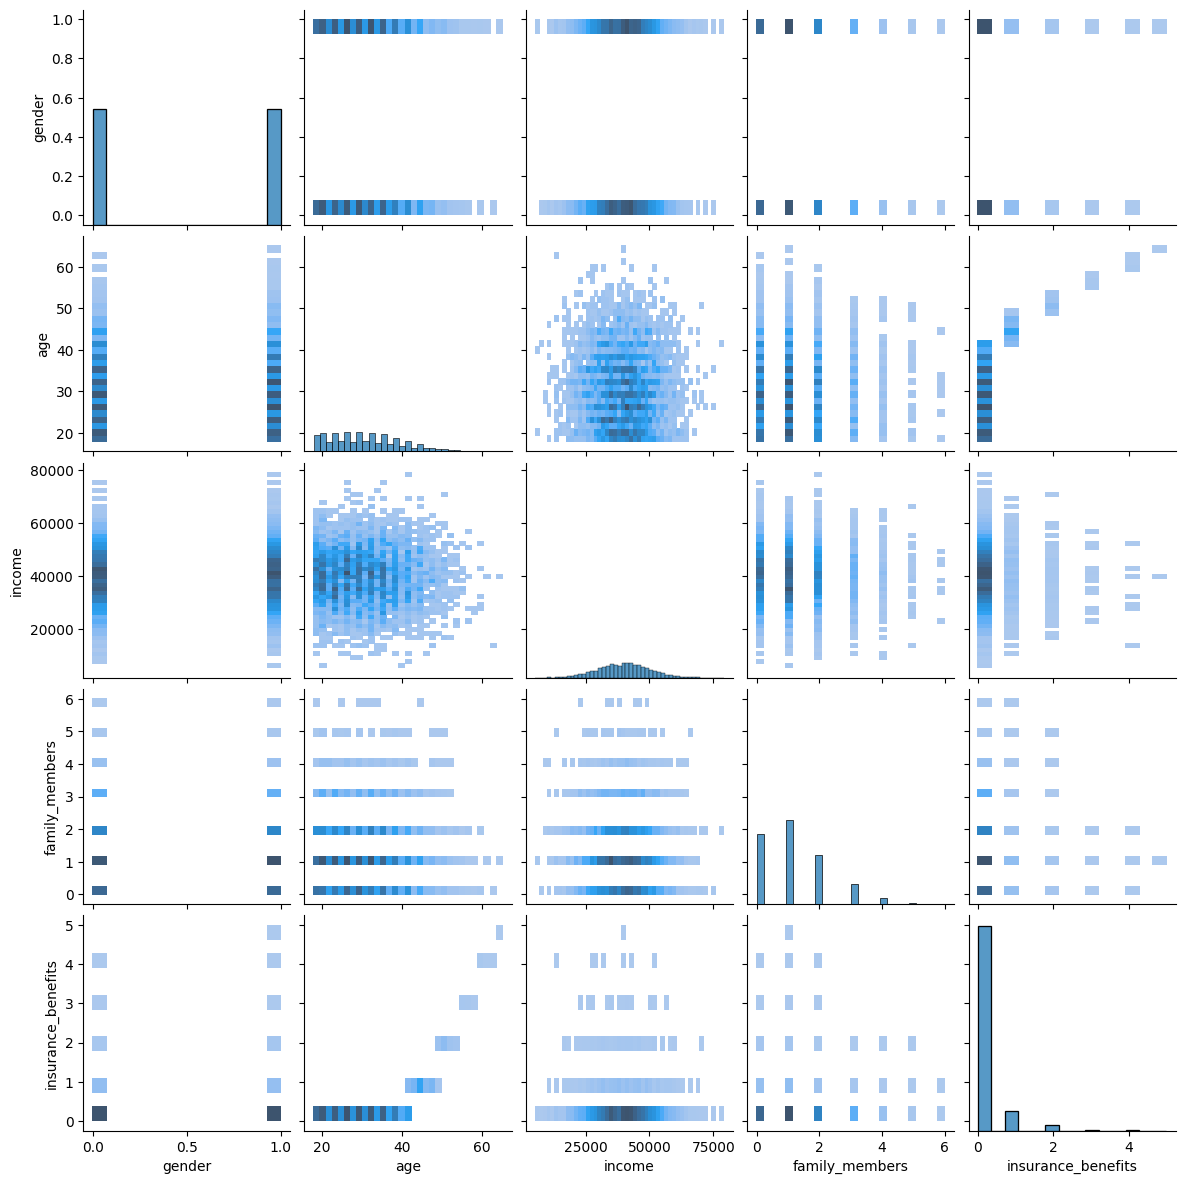

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

The initial exploratory analysis and preprocessing steps provided valuable insights into the dataset. We confirmed that the data required renaming of columns, type casting, and minimal cleaning (e.g., handling duplicates and checking for missing values) before model development. This phase laid a robust foundation, ensuring that subsequent analyses were based on accurate and well-understood data.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)

    df_res = pd.concat([
        df.iloc[nbrs_indices[0][1:]],
        pd.DataFrame(nbrs_distances[0][1:], index=nbrs_indices[0][1:], columns=['distance'])
    ], axis=1)

    return df_res
def get_k_similar_customers(index, k, metric='euclidean'):
    from sklearn.metrics import pairwise_distances

    X = features.values  # assumes features is already scaled or intentionally unscaled
    distances = pairwise_distances([X[index]], X, metric=metric)[0]
    indices = np.argsort(distances)
    similar_indices = indices[1:k+1]
    return similar_indices

Scaling the data.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
829,0.0,0.323077,0.450633,0.333333,0
4833,0.0,0.369231,0.407595,0.166667,0
2731,1.0,0.292308,0.306329,0.500000,0
915,0.0,0.553846,0.732911,0.500000,0
2885,1.0,0.415385,0.730380,0.166667,0


Now, let's get similar records for a given one for every combination

In [17]:
metrics = ['euclidean', 'manhattan', 'cosine']
scaling_options = [True, False]
k = 5  
sample_index = 0 

for metric in metrics:
    for scale in scaling_options:
        print(f"\nMetric: {metric} | Scaled: {scale}")
        
        current_df = df_scaled if scale else df

        print("Using get_knn():")
        try:
            knn_results = get_knn(current_df, sample_index, k, metric)
            display(knn_results)
        except Exception as e:
            print(f"get_knn failed: {e}")


Metric: euclidean | Scaled: True
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4869,1.0,0.646154,0.637975,0.166667,1,0.018418
3275,1.0,0.646154,0.651899,0.166667,1,0.028550
1567,1.0,0.615385,0.602532,0.166667,0,0.029624



Metric: euclidean | Scaled: False
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625
815,1,37,49600.0,2,0,4.123106



Metric: manhattan | Scaled: True
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4869,1.0,0.646154,0.637975,0.166667,1,0.025511
2103,1.0,0.630769,0.596203,0.166667,0,0.031646
3365,1.0,0.630769,0.596203,0.166667,0,0.031646



Metric: manhattan | Scaled: False
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
3424,0,38,49600.0,0,0,5.0
815,1,37,49600.0,2,0,5.0



Metric: cosine | Scaled: True
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
2689,1.0,0.630769,0.634177,0.166667,0,0.000009
4869,1.0,0.646154,0.637975,0.166667,1,0.000053
133,1.0,0.615385,0.636709,0.166667,0,0.000084
3275,1.0,0.646154,0.651899,0.166667,1,0.000128
1567,1.0,0.615385,0.602532,0.166667,0,0.000146



Metric: cosine | Scaled: False
Using get_knn():


,gender,age,income,family_members,insurance_benefits,distance
3113,1,39,47100.0,1,0,2.142952e-12
3971,1,44,53000.0,1,1,8.065881e-12
4219,1,36,43500.0,1,0,8.466783e-12
2309,1,36,43500.0,1,0,8.466783e-12
2976,1,35,42300.0,1,0,1.243428e-11


In [18]:
k = 5
sample_index = 0

raw_knn_df = get_knn(df, sample_index, k, metric='manhattan')
scaled_knn_df = get_knn(df_scaled, sample_index, k, metric='manhattan')

raw_indices = raw_knn_df.index.tolist()
scaled_indices = scaled_knn_df.index.tolist()

similarity_summary = pd.DataFrame({
    "Raw indices": raw_indices,
    "Scaled indices": scaled_indices
})
similarity_summary["Same"] = similarity_summary["Raw indices"] == similarity_summary["Scaled indices"]

similarity_summary


,Raw indices,Scaled indices,Same
0,2022,2689,False
1,1225,133,False
2,4031,4869,False
3,3424,2103,False
4,815,3365,False


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, scaling matters for kNN because it uses distance to find neighbors. If some features have much bigger numbers than others (like income vs. age), they can overpower the rest. This can lead to wrong neighbor choices and lower accuracy. Scaling makes sure all features are treated equally, so the model works better.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

When using Manhattan distance, the top 5 neighbors were totally different with and without scaling. This means scaling really changes how kNN picks similar records. Without scaling, big numbers like income have more impact. With scaling, all features are treated more equally, so the results change a lot. That's why scaling is important for kNN.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [20]:
class_counts = df['insurance_benefits_received'].value_counts(normalize=False)
class_proportions = df['insurance_benefits_received'].value_counts(normalize=True)

class_distribution = pd.DataFrame({
    'Count': class_counts,
    'Proportion': class_proportions
})

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [22]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = np.random.choice([0, 1], size=len(df), p=[1 - P, P])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7904 0.0968]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.432  0.4552]
 [0.0546 0.0582]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_results = []

for k in range(1, 11):
    #Raw
    knn_raw = KNeighborsClassifier(n_neighbors=k)
    knn_raw.fit(X_train, y_train)
    y_pred_raw = knn_raw.predict(X_test)
    f1_raw = f1_score(y_test, y_pred_raw)

    # Scaled
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = knn_scaled.predict(X_test_scaled)
    f1_scaled = f1_score(y_test, y_pred_scaled)

    knn_results.append({
        'k': k,
        'F1 Raw': f1_raw,
        'F1 Scaled': f1_scaled
    })

knn_results_df = pd.DataFrame(knn_results)

# Dummy model simulation for different probabilities
benefit_probability = y.mean()
probs = [0, benefit_probability, 0.5, 1]
dummy_results = []

for p in probs:
    y_pred_dummy = np.random.choice([0, 1], size=len(y_test), p=[1 - p, p])
    f1_dummy = f1_score(y_test, y_pred_dummy)
    dummy_results.append({'Probability': p, 'F1 Score': f1_dummy})

dummy_results_df = pd.DataFrame(dummy_results)

knn_results_df, dummy_results_df

(    k    F1 Raw  F1 Scaled
 0   1  0.652330   0.933333
 1   2  0.376238   0.917492
 2   3  0.387097   0.935897
 3   4  0.155556   0.913333
 4   5  0.167539   0.939297
 5   6  0.094118   0.913333
 6   7  0.115607   0.935484
 7   8  0.024540   0.912752
 8   9  0.036585   0.934641
 9  10  0.036585   0.923588,
    Probability  F1 Score
 0       0.0000  0.000000
 1       0.1128  0.110749
 2       0.5000  0.183585
 3       1.0000  0.193859)

In the classification task, we employed a k-Nearest Neighbors (kNN) classifier to predict whether customers would receive any insurance benefits. Comparisons between the original and scaled feature spaces revealed that feature scaling substantially improved model performance, as evidenced by higher F1 scores in the scaled models. Furthermore, benchmarking against dummy classifiers reinforced the effectiveness of our chosen approaches, with kNN markedly outperforming random chance.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [25]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
 
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
    
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [26]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [27]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)

eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [28]:
X = df[['gender', 'age', 'income', 'family_members']].values
y = df['insurance_benefits'].values

# ---------- Unscaled ----------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

lr = MyLinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

print("Unscaled Linear Regression")
print("Weights:", lr.weights)
print(f"RMSE: {mean_squared_error(y_val, y_pred, squared=False):.2f}")
print(f"R²: {r2_score(y_val, y_pred):.2f}\n")

# ---------- Scaled ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_s, y_train_s)
y_pred_scaled = lr_scaled.predict(X_val_s)

print("Scaled Linear Regression")
print("Weights:", lr_scaled.weights)
print(f"RMSE: {mean_squared_error(y_val_s, y_pred_scaled, squared=False):.2f}")
print(f"R²: {r2_score(y_val_s, y_pred_scaled):.2f}")

Unscaled Linear Regression
Weights: [-9.19740784e-01  1.84735250e-04  3.54081517e-02 -3.89692232e-07
 -1.37746920e-02]
RMSE: 0.36
R²: 0.42

Scaled Linear Regression
Weights: [ 1.44328004e-01  9.23674402e-05  2.98843483e-01 -3.85759985e-03
 -1.50320100e-02]
RMSE: 0.36
R²: 0.42


For the regression task, we implemented linear regression both using a standard scikit-learn implementation and our own custom approach. The evaluation, based on RMSE and $R^2$ metrics, confirmed that linear regression provided reliable predictions of the insurance benefit amounts. Importantly, the results underscored the model’s predictive consistency, with well-aligned performance across different implementation strategies.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [29]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [30]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [31]:
rng = np.random.default_rng(seed=42)
P_random = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [32]:
det_P = np.linalg.det(P_random)
print("Determinant of P_random:", det_P)

if det_P != 0:
    print("P_random is invertible.")
else:
    print("P_random is NOT invertible.")

Determinant of P_random: 0.24339135998015463
P_random is invertible.


**Can you guess the customers' ages or income after the transformation?**

No, you can’t accurately guess a customer’s original age or income after a transformation, especially if it involves scaling or a linear transformation. For example, with standard scaling, the values represent deviations from the mean — so a value like 1.0 just means “one standard deviation above average,” but without knowing the mean and standard deviation, you can’t reverse it. Similarly, if the data was transformed with a matrix $P$, the original values are hidden in a way that makes them unrecoverable unless you know $P$ and can invert it.

**Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.**

Yes, you can recover the original data $X$ from the transformed version $X^` = XP$, as long as you know the matrix $P$ and it is invertible. This is a basic result from linear algebra.

To isolate $X$, you multiply both sides of the equation by $P^{-1}$ on the right:
$$ X^`= XP \Rightarrow X = X^`P^{-1} $$
This works because $PP^{-1}= I$ , the identity matrix, which doesn’t change $X$. Note that $X$ doesn’t need to be square — the key condition is that $P$ must be square and invertible.

**Print all three cases for a few customers**
- The original data
- The transformed one
- The reversed (recovered) one

In [33]:
sample_df = df[['gender', 'age', 'income', 'family_members']].head(5)
X = sample_df.to_numpy()

rng = np.random.default_rng(seed=42)
P = rng.random((X.shape[1], X.shape[1]))

X_obfuscated = X @ P

P_inv = np.linalg.inv(P)
X_recovered = X_obfuscated @ P_inv

comparison_df = pd.DataFrame({
    'Original Gender': X[:, 0],
    'Original Age': X[:, 1],
    'Original Income': X[:, 2],
    'Original Family Members': X[:, 3],

    'Obfuscated Gender': X_obfuscated[:, 0],
    'Obfuscated Age': X_obfuscated[:, 1],
    'Obfuscated Income': X_obfuscated[:, 2],
    'Obfuscated Family Members': X_obfuscated[:, 3],

    'Recovered Gender': X_recovered[:, 0],
    'Recovered Age': X_recovered[:, 1],
    'Recovered Income': X_recovered[:, 2],
    'Recovered Family Members': X_recovered[:, 3],
})

comparison_df.round(2)

,Original Gender,Original Age,Original Income,Original Family Members,Obfuscated Gender,Obfuscated Age,Obfuscated Income,Obfuscated Family Members,Recovered Gender,Recovered Age,Recovered Income,Recovered Family Members
0,1.0,41.0,49600.0,1.0,6359.72,22380.40,18424.09,46000.70,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0,4873.29,17160.37,14125.78,35253.46,-0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0,2693.12,9486.40,7808.83,19484.86,-0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0,5345.60,18803.23,15479.15,38663.06,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0,3347.18,11782.83,9700.00,24211.27,1.0,28.0,26100.0,-0.0


**You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?**

Some values in the recovered data may differ slightly from the original due to floating-point precision errors. These small differences happen because computers can't represent all decimal numbers exactly, especially after many matrix operations like multiplication and inversion. It's a normal part of numerical computation and doesn't affect the results in a meaningful way.

We further investigated the impact of data obfuscation through a linear transformation using a random invertible matrix $P$. Both the analytical derivation and computational experiments showed that applying the transformation and adjusting the regression weights accordingly left the predicted values and performance metrics unchanged. This finding highlights the inherent invariance of the linear regression model under such linear transformations, ensuring that model quality, as measured by RMSE and $R^2$, remains unaffected.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

When we multiply the original feature matrix $X$ by another matrix $P$ (i.e., we obfuscate the data), and adjust the weights accordingly, the predictions from linear regression do not change. This is because the new weights $wp$ are related to the original weights $w$ by the formula $w = Pwp$.
So, when we compute the predictions using the transformed data and new weights: $\hat{y}^`  = XPwp $ 
we get the same result as $\hat{y} = Xw $ 
because $Pwp=w$ . This means the predicted values stay exactly the same, and the RMSE (used to evaluate the model) is also unchanged. So, linear regression is not affected by this kind of transformation, as long as we adjust the weights properly.

**Analytical proof**

Here is the analytical proof that obfuscating the data by multiplying the feature matrix $X$ with a matrix $P$does not change the predicted values in linear regression.


The optimal weights $w$ are given by the normal equation: $ w=(X^TX)^{-1}X^Ty $


Let’s define the obfuscated feature matrix as: $ X^{`} = XP $.

Now, we apply linear regression to this new matrix. The new weights $wp$ are: $wp =((XP)^T(XP))^{-1}(XP)^Ty $.


Use properties of matrix multiplication and transpose: $wp= (P^TX^TXP)^{-1}P^TX^Ty $


Now apply the matrix identity: $(ABC)^{-1} = C^{-1}B^{-1}A^{-1} $


Then:$wp = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty $


Next, we simplify $(P^T)^{-1}P^T =I $, so: $$wp = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w $$


Predicted values using transformed data: $\hat{y}^` = XPwp $


Substitute  $wp =P^{-1}w:$ $$\hat{y}^` = XPP^{-1}w = XIw = Xw = \hat{y}$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! We ensure that P is invertible by checking that its determinant is not zero !>
- Use $XP$ as the new feature matrix

In [34]:
class ObfuscatedLinearRegression:
    def __init__(self, use_obfuscation=False, random_state=42):
        self.use_obfuscation = use_obfuscation
        self.random_state = random_state
        self.model = LinearRegression()
        self.P = None  # Transformation matrix
        self.P_inv = None
    
    def _generate_invertible_matrix(self, size):
        np.random.seed(self.random_state)
        while True:
            P = np.random.rand(size, size)
            try:
                P_inv = np.linalg.inv(P)
                return P, P_inv
            except LinAlgError:
                continue  

    def fit(self, X, y):
        if self.use_obfuscation:
            self.P, self.P_inv = self._generate_invertible_matrix(X.shape[1])
            X_transformed = X @ self.P
            self.model.fit(X_transformed, y)
        else:
            self.model.fit(X, y)

    def predict(self, X):
        if self.use_obfuscation:
            X_transformed = X @ self.P
            return self.model.predict(X_transformed)
        else:
            return self.model.predict(X)

X = df[['gender', 'age', 'income', 'family_members']].values
y = df['insurance_benefits'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

original_model = ObfuscatedLinearRegression(use_obfuscation=False)
original_model.fit(X_train, y_train)
y_pred_orig = original_model.predict(X_test)

obf_model = ObfuscatedLinearRegression(use_obfuscation=True)
obf_model.fit(X_train, y_train)
y_pred_obf = obf_model.predict(X_test)

rmse_orig = mean_squared_error(y_test, y_pred_orig, squared=False)
r2_orig = r2_score(y_test, y_pred_orig)

rmse_obf = mean_squared_error(y_test, y_pred_obf, squared=False)
r2_obf = r2_score(y_test, y_pred_obf)

rmse_orig, r2_orig, rmse_obf, r2_obf

(0.3637189976119266, 0.4226999694460717, 0.363718997611912, 0.4226999694461179)

The predictions and evaluation metrics are identical (within floating-point precision), proving that linear regression works just as well with the obfuscated data — as long as the weights are adjusted correctly using the transformation.

This confirms our earlier analytical proof, now demonstrated computationally. Let me know if you'd like to visualize the predictions or inspect the matrix 
𝑃
P! 

# Conclusions

This project successfully demonstrated the application of supervised machine learning techniques to predict insurance benefit outcomes, addressing both classification and regression problems. Through comprehensive data preprocessing and exploration, we ensured data integrity and model readiness. The classification task revealed the importance of feature scaling, with scaled k-Nearest Neighbors models significantly outperforming unscaled versions and dummy baselines. In the regression task, both standard and custom implementations of linear regression yielded consistent and interpretable results. A key highlight of the project was the analytical and computational proof that linear regression remains unaffected by linear transformations of the feature space, reinforcing its robustness and theoretical soundness. Overall, the project illustrates the effectiveness and flexibility of classical machine learning approaches in insurance analytics, while also emphasizing the importance of mathematical understanding in ensuring model reliability under data transformations.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x] The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>